In [1]:
# Declares the classifications
diseases = [('an', 'Acne'), ('ac', 'Actinic_Keratosis'), ('be', 'Benign_tumors'),
           ('bu', 'Bullous'),('ca', 'Candidiasis'), ('de', 'DrugEruption'),
          ('ec','Eczema'), ('ib','Infestations_Bites'),('li','Lichen'),
          ('lu','Lupus'), ('mo','Moles'),('ps','Psoriasis'),
           ('ro','Rosacea'), ('sk','Seborrh_Keratoses'),('sc','SkinCancer'),
           ('sd','Sun_Sunlight_Damage'), ('ti','Tinea'),('un','Unknown_Normal'),
           ('vt','Vascular_Tumors'), ('va','Vasculitis'),('vi','Vitiligo'),
           ('wa','Warts')]

In [2]:
# Set the file path and preforms name changes on files with whitespace
import os

root_dir = "SkinDisease"
classes = os.listdir(root_dir)

for class_name in classes:
    if class_name.strip() != class_name:
        print(f"Warning: Inconsistent label - '{class_name}' has whitespace.")

for class_name in os.listdir(root_dir):
    os.rename(os.path.join(root_dir, class_name),
              os.path.join(root_dir, class_name.strip().lower().replace(" ", "_")))

In [3]:
import os

for class_name in os.listdir(root_dir):
    new_name = class_name.strip().lower().replace(" ", "_")
    # Only rename if the new name is different from the original
    if class_name != new_name:
        try:
            os.rename(os.path.join(root_dir, class_name),
                      os.path.join(root_dir, new_name))
            print(f"Renamed: {class_name} -> {new_name}")
        except PermissionError:
            print(f"Permission denied when renaming: {class_name}")
        except Exception as e:
            print(f"Error renaming {class_name}: {e}")
    else:
        print(f"Skipping {class_name} as it doesn't need renaming")

Skipping test as it doesn't need renaming
Skipping train as it doesn't need renaming


In [4]:
# Reads the images
import os
import cv2
numOfImagesPerClass = 300 # Luqman: This was about as much as my machine could handle. To many images and the models just take to long to process and train.
                            # To many images and the models just take to long to process and train. I ran into ram issues, not having enough memory
# Set your folder path to where the dataset is, After downloading it I placed it in the same folder.
folder_path = r'SkinDisease/train/' # Loads the training set

# Create an empty list to store images
images = []


# Loop through all files in the folder
for disease in diseases:  
    imageList = []
    imagesLoaded = 0
    newFolderPath = folder_path + disease[1]
    image_files = [f for f in os.listdir(newFolderPath)]
    for filename in image_files: # Choose how many images to load from each folder here. Remove [] to load all of them.
        file_path = os.path.join(newFolderPath, filename)
        img = cv2.imread(file_path)
        if img is not None:
            imageList.append(img)
        else:
            print(f"Warning: Failed to read {filename}")
        imagesLoaded += 1
        if imagesLoaded == numOfImagesPerClass:
            imagesLoaded = 0
            break
    images.append(imageList)

total_images = sum(len(imageList) for imageList in images)
print(f"Total images loaded: {total_images }")

Total images loaded: 6502


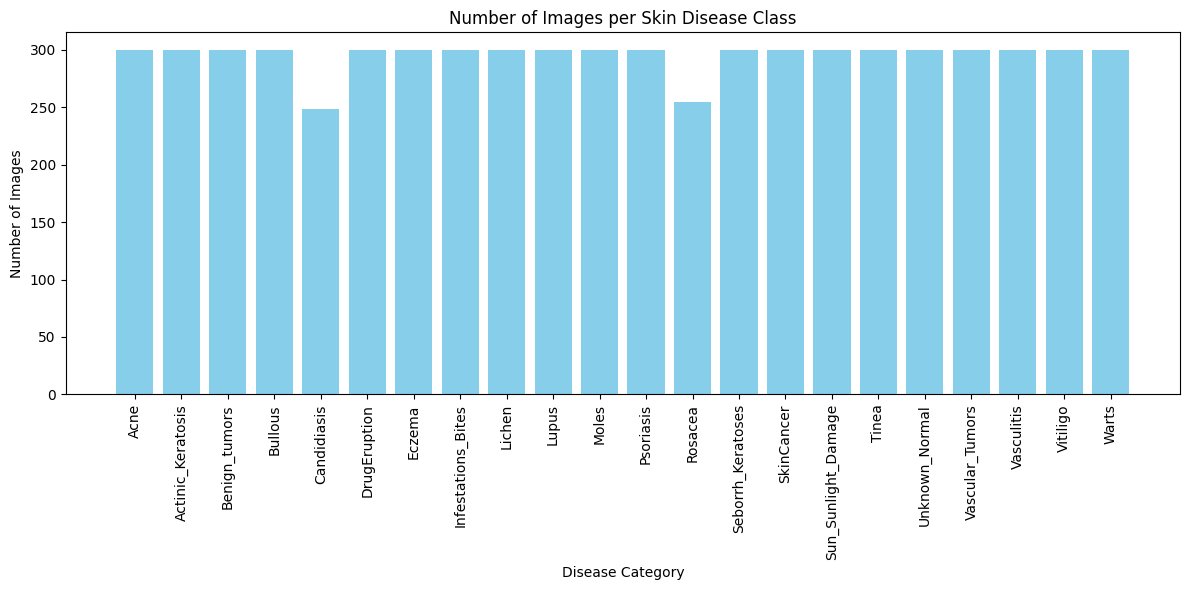

In [5]:
# Shows that that every class has the same number of images
import matplotlib.pyplot as plt

# Count how many images per class
image_counts = [len(img_list) for img_list in images]
class_names = [name for _, name in diseases]

# Plot the bar chart
plt.figure(figsize=(12, 6))
plt.bar(class_names, image_counts, color='skyblue')
plt.xticks(rotation=90)
plt.xlabel("Disease Category")
plt.ylabel("Number of Images")
plt.title("Number of Images per Skin Disease Class")
plt.tight_layout()
plt.show()

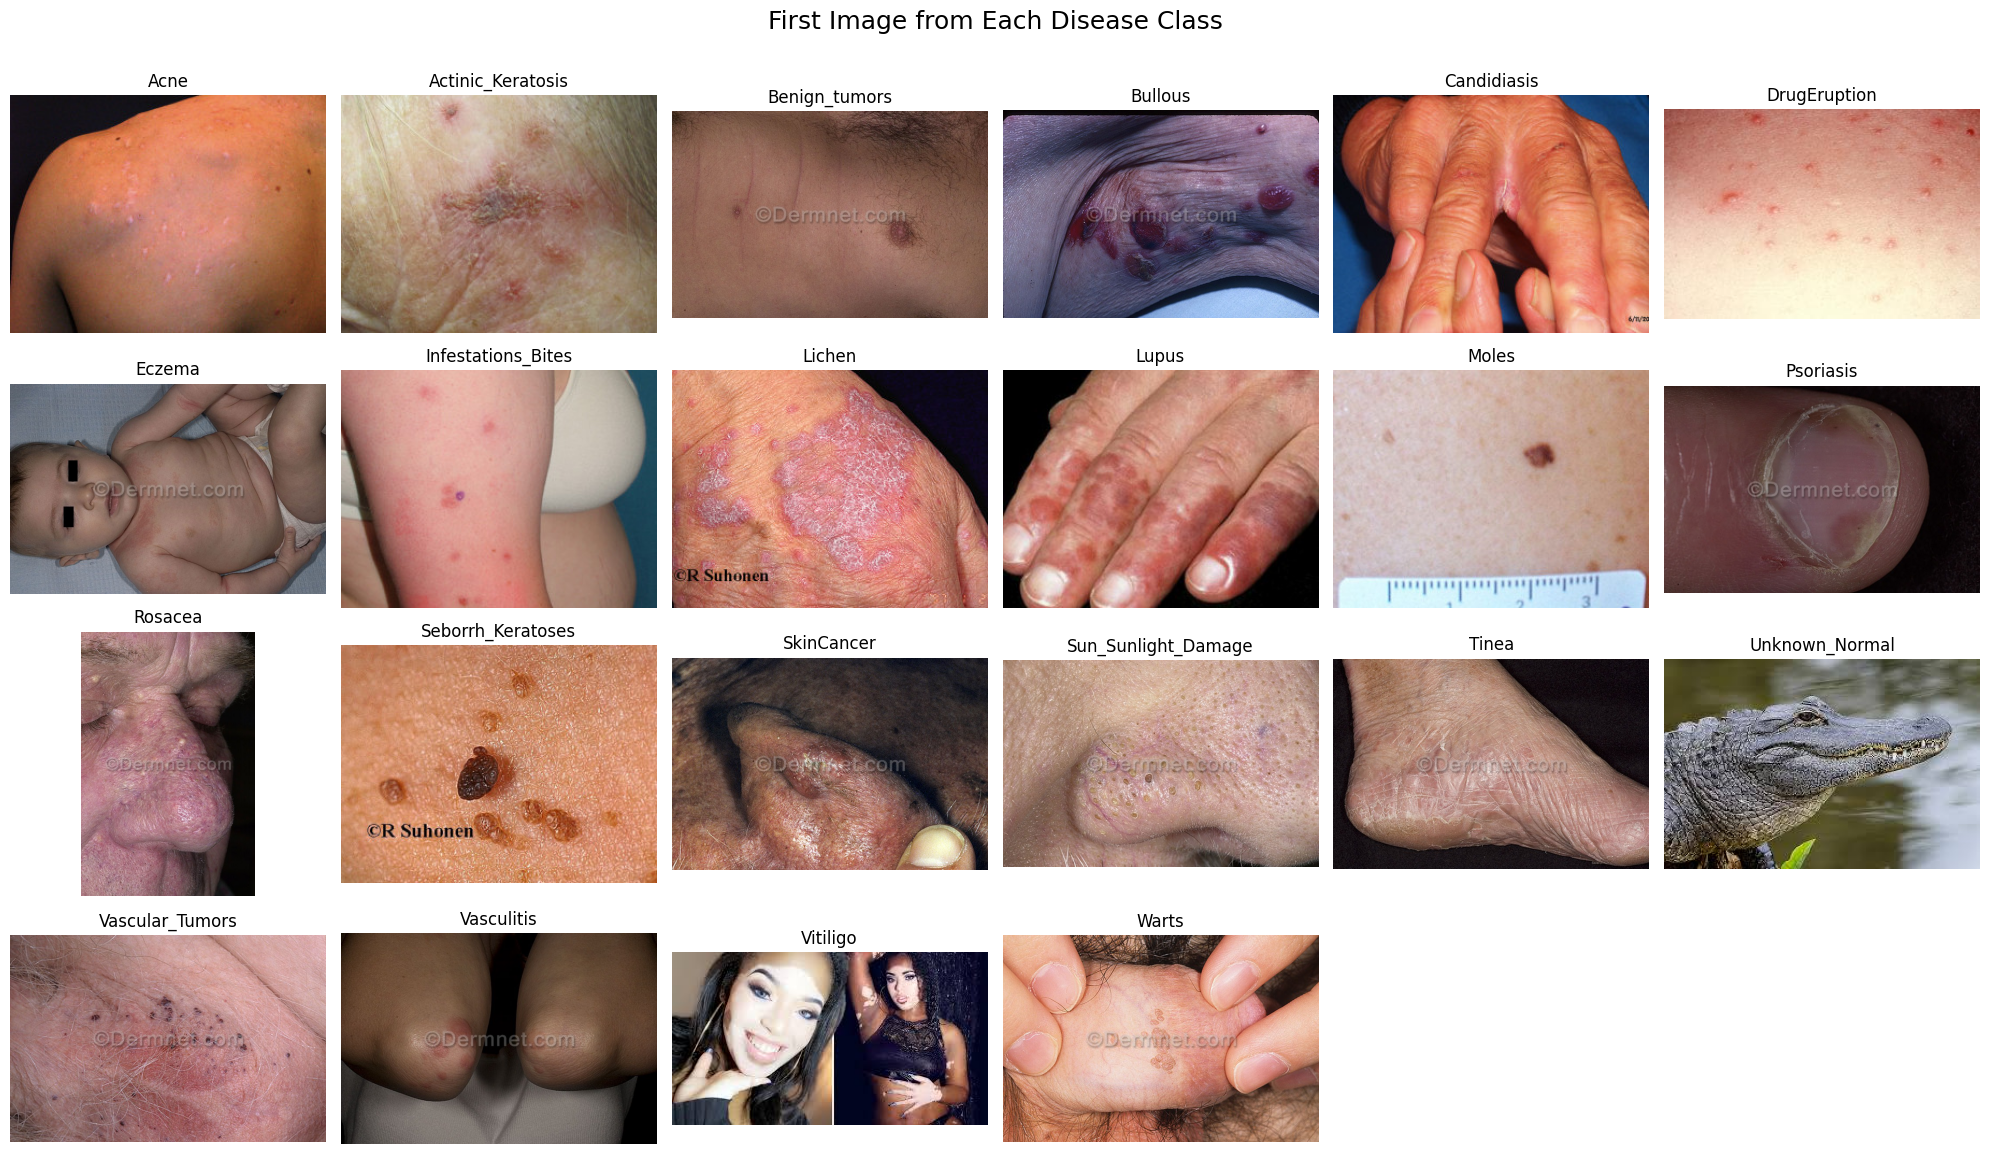

In [6]:
plt.figure(figsize=(20, 12))
for idx, img_list in enumerate(images):
    if img_list:  # Check if there's at least one image
        img = cv2.cvtColor(img_list[10], cv2.COLOR_BGR2RGB)
        plt.subplot(4, 6, idx + 1)
        plt.imshow(img)
        plt.title(diseases[idx][1])
        plt.axis('off')
plt.suptitle("First Image from Each Disease Class", fontsize=18)
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()

In [7]:
# Defines all functions for the preprosseing of the images
import numpy as np

# Resize to 250x250
def resize_image(image, size=(250, 250)):
    return cv2.resize(image, size)

# Apply Median Filter
def apply_median_filter(image):
    return cv2.medianBlur(image, 5)

# Morphological Operation
def morphological_clean(image):
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    return cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)

# Crop Black Borders (then resize to 150x150)
def crop_black_borders(image, final_size=(150, 150)):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        x, y, w, h = cv2.boundingRect(contours[0])
        cropped = image[y:y+h, x:x+w]
        return cv2.resize(cropped, final_size)
    return cv2.resize(image, final_size)

# Segment the lesion and set black background
def segment_lesion(image):
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    _, mask = cv2.threshold(a, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    lesion = cv2.bitwise_and(image, image, mask=mask)
    black_bg = np.zeros_like(image)
    mask_inv = cv2.bitwise_not(mask)
    background = cv2.bitwise_and(black_bg, black_bg, mask=mask_inv)
    
    combined = cv2.add(lesion, background)
    return combined

In [1]:
# Function to call al preprossing functions and apply the changes to the image.
def preprocess_image(image):
    image = resize_image(image)  # Resize to 250x250
    image = apply_median_filter(image)
    image = morphological_clean(image)
    image = crop_black_borders(image)  # Resize to 150x150
    image = segment_lesion(image)
    return image
 # 1 because we only loaded 1 image per classification, change this when needed.

In [9]:
processed_images = []

for img_list in images:
    processed_list = []
    for img in img_list:
        processedImage = preprocess_image(img)
        resized = cv2.resize(processedImage, (224, 224))  # Resize to 224x224, this is generally the size cnn models use.
        normalized =  resized / 255.0            # Normalize to [0,1]
        processed_list.append(normalized)
    processed_images.append(processed_list)

print("Preprocessing done. Images resized to 224x224 and normalized.")

Preprocessing done. Images resized to 224x224 and normalized.


In [10]:
# Augment the images and add to classes that don't have enought images
import numpy as np

augmented_images = []
currentClass = 0

for class_images in processed_images:
    aug_list = []
    aug_add = []
    # Add in all the original images
    for img in class_images:
        aug_list.append(img)
    # if class has less than the desired images perclass, augment them and add the images   
    if image_counts[currentClass] < numOfImagesPerClass:
        numImagesNeeded = numOfImagesPerClass - image_counts[currentClass]
        for img in aug_list:
            # Horizontal Flip
            flipped = cv2.flip((img * 255), 1)
    
            # Rotation
            center = (112, 112)
            M = cv2.getRotationMatrix2D(center, 15, 1.0)
            rotated = cv2.warpAffine((img * 255), M, (224, 224))
    
            # Brightness Increase
            bright = cv2.convertScaleAbs((img * 255), alpha=1.2, beta=30)
            # Adds the image and checks if number of images to be added is 0
            aug_add.append(flipped/255.0)
            numImagesNeeded -= 1
            if numImagesNeeded <= 0:
                break
            aug_add.append(rotated/255.0)
            numImagesNeeded -= 1
            if numImagesNeeded <= 0:
                break
            aug_add.append(bright/255.0)
            numImagesNeeded -= 1
            if numImagesNeeded <= 0:
                break

    aug_list = aug_list + aug_add
    augmented_images.append(aug_list)
    currentClass += 1 
print("Augmentation done: flip, rotate, brightness.")

Augmentation done: flip, rotate, brightness.


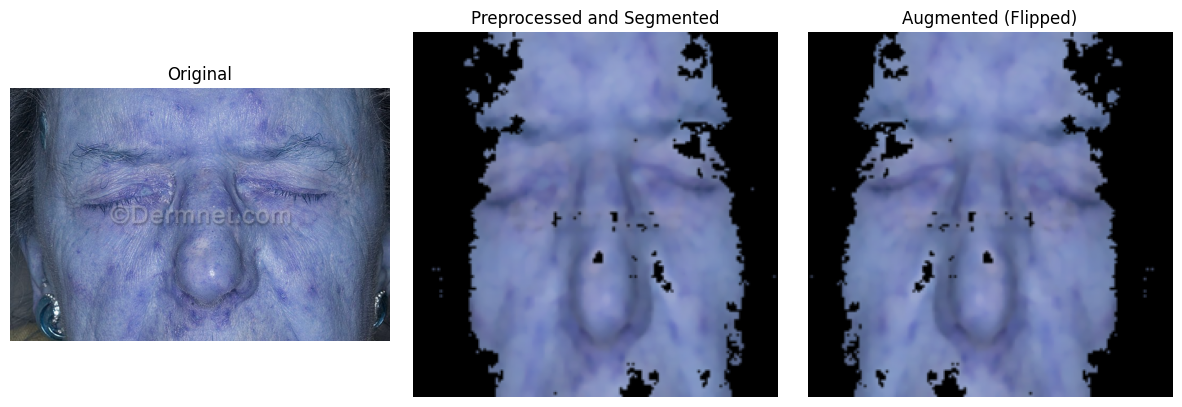

In [11]:
# Show original, segmented, and augmented for one sample
i = 12 # First class
j = 0  # First image

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(images[i][j])
plt.title("Original")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(processed_images[i][j], cmap='gray')
plt.title("Preprocessed and Segmented")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(augmented_images[i][254])  # First aug: flipped
plt.title("Augmented (Flipped)")
plt.axis('off')

plt.tight_layout()
plt.show()

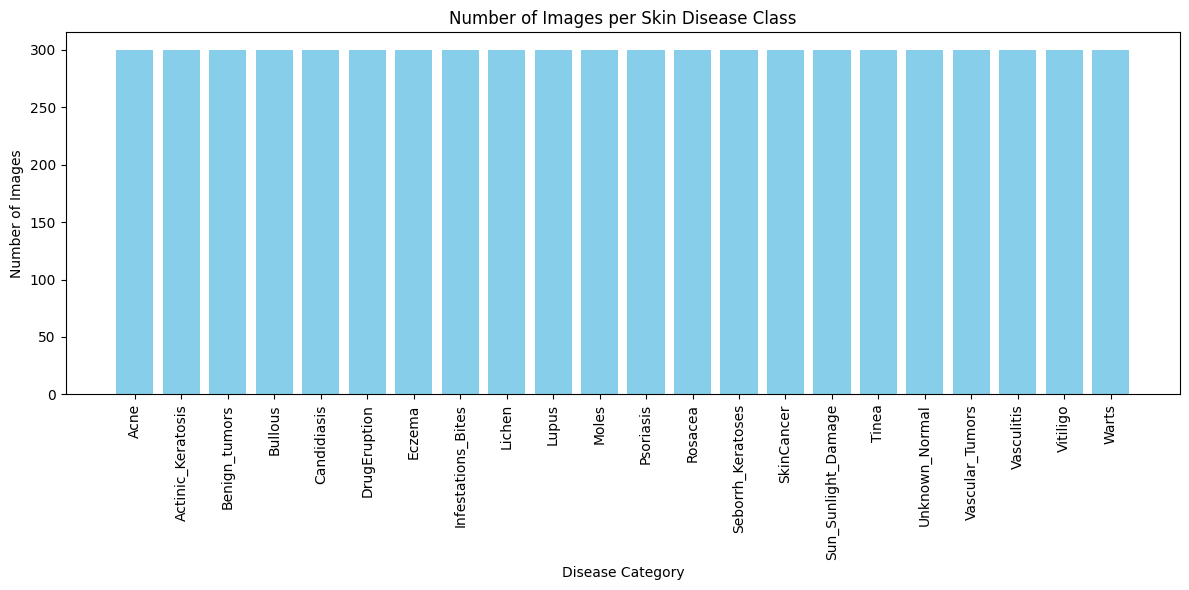

In [12]:
# Shows that every class now the same number of images
import matplotlib.pyplot as plt

# Count how many images per class
image_counts = [len(img_list) for img_list in augmented_images]
class_names = [name for _, name in diseases]

# Plot the bar chart
plt.figure(figsize=(12, 6))
plt.bar(class_names, image_counts, color='skyblue')
plt.xticks(rotation=90)
plt.xlabel("Disease Category")
plt.ylabel("Number of Images")
plt.title("Number of Images per Skin Disease Class")
plt.tight_layout()
plt.show()

In [15]:
# fallen the list and convert into trainable format
import numpy as np

# Flatten the list
flat_augmented = []
for img_list in augmented_images:
    for img in img_list:
        flat_augmented.append(img)
        
flat_augmented = np.squeeze(np.array(flat_augmented))

In [16]:
# Get the validation labels
from sklearn.preprocessing import LabelEncoder
labels = []
for c in diseases:
    labels.extend([c[0] for i in range(numOfImagesPerClass)]) 
le = LabelEncoder()
encoded_labels = le.fit_transform(labels) 

In [17]:
#Feature Extraction with RestNet50
# Warning! it took my machine 10 minutes to run this.
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model
import numpy as np

# Load base model
base_model = ResNet50(weights='imagenet', include_top=False, pooling='avg')
model = Model(inputs=base_model.input, outputs=base_model.output)

# Preprocess image and extract features
features = model.predict(preprocess_input(flat_augmented))  # image_batch shape: (batch_size, 224, 224, 3)


207/207 [==============================] - 632s 3s/step


In [18]:
#Feature Extraction with VGG16 
# Warning! it took my machine 30 minutes to run this.
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras import layers, models
from tensorflow.keras.layers import GlobalAveragePooling2D

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
output = GlobalAveragePooling2D()(base_model.output)
model = Model(inputs=base_model.input, outputs=output)

VGGfeatures = model.predict(preprocess_input(flat_augmented))

207/207 [==============================] - 1924s 9s/step


In [19]:
# SVC with external feature extration with ResNet50
# using linear svc because the normal one takes too long
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


X_train, X_test, y_train, y_test = train_test_split(features, encoded_labels, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# PCA
pca = PCA(n_components=10) # Reduce dimentions for faster run time
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Train model
clf = LinearSVC(max_iter=10000)
clf.fit(X_train_pca, y_train)

# Predict
y_pred = clf.predict(X_test_pca)

print(classification_report(
    y_test,
    y_pred,
    labels=np.unique(y_test),                     # Only include classes present in y_test
    target_names=le.inverse_transform(np.unique(y_test))  # Convert back to original names
))

              precision    recall  f1-score   support

          ac       0.00      0.00      0.00        72
          an       0.17      0.11      0.14        70
          be       0.11      0.13      0.12        53
          bu       0.00      0.00      0.00        59
          ca       0.00      0.00      0.00        61
          de       0.00      0.00      0.00        55
          ec       0.06      0.45      0.10        51
          ib       0.00      0.00      0.00        64
          li       0.00      0.00      0.00        60
          lu       0.00      0.00      0.00        61
          mo       0.03      0.03      0.03        64
          ps       0.00      0.00      0.00        59
          ro       0.09      0.09      0.09        54
          sc       0.13      0.15      0.14        59
          sd       0.04      0.03      0.04        61
          sk       0.14      0.70      0.24        53
          ti       0.00      0.00      0.00        44
          un       0.08    

C:\Users\luqma\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\luqma\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\luqma\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [20]:
# SVC with external feature extration with VGG16
# Used linear SVC because normal svc took to long
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

X = VGGfeatures.reshape((VGGfeatures.shape[0], -1))

X_train, X_test, y_train, y_test = train_test_split(X, encoded_labels, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# PCA
pca = PCA(n_components=10)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Train model
clf = LinearSVC(max_iter=10000)
clf.fit(X_train_pca, y_train)

# Predict
y_pred = clf.predict(X_test_pca)

from sklearn.metrics import classification_report
print(classification_report(
    y_test,
    y_pred,
    labels=np.unique(y_test),
    target_names=le.inverse_transform(np.unique(y_test))
))

              precision    recall  f1-score   support

          ac       0.09      0.01      0.02        72
          an       0.10      0.07      0.08        70
          be       0.00      0.00      0.00        53
          bu       0.00      0.00      0.00        59
          ca       0.17      0.15      0.16        61
          de       0.07      0.09      0.08        55
          ec       0.07      0.45      0.12        51
          ib       0.00      0.00      0.00        64
          li       0.09      0.03      0.05        60
          lu       0.00      0.00      0.00        61
          mo       0.12      0.06      0.08        64
          ps       0.00      0.00      0.00        59
          ro       0.00      0.00      0.00        54
          sc       0.00      0.00      0.00        59
          sd       0.05      0.02      0.02        61
          sk       0.13      0.60      0.21        53
          ti       0.04      0.07      0.05        44
          un       0.11    

In [16]:
# Random Forest with external feature extration with ResNet50
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

RX_train, RX_test, Ry_train, Ry_test = train_test_split(features, encoded_labels, test_size=0.2, random_state=42)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(RX_train, Ry_train)

# Predict
Ry_pred = clf.predict(RX_test)

# Evaluate
#print(classification_report(y_test, y_pred, target_names=le.classes_))
'''from collections import Counter

print("Train:", Counter(y_train))
print("Test:", Counter(y_test))'''


print(classification_report(
    Ry_test,
    Ry_pred,
    labels=np.unique(Ry_test),                     # Only include classes present in y_test
    target_names=le.inverse_transform(np.unique(Ry_test))  # Convert back to original names
))

              precision    recall  f1-score   support

          ac       0.18      0.11      0.14        72
          an       0.12      0.17      0.14        70
          be       0.15      0.30      0.20        53
          bu       0.17      0.10      0.13        59
          ca       0.27      0.34      0.30        61
          de       0.15      0.11      0.13        55
          ec       0.09      0.14      0.11        51
          ib       0.26      0.16      0.19        64
          li       0.05      0.03      0.04        60
          lu       0.14      0.08      0.10        61
          mo       0.29      0.28      0.29        64
          ps       0.03      0.02      0.02        59
          ro       0.17      0.26      0.20        54
          sc       0.17      0.22      0.19        59
          sd       0.12      0.10      0.11        61
          sk       0.28      0.53      0.36        53
          ti       0.08      0.14      0.10        44
          un       0.24    

In [24]:
# Random Forest with external feature extration with VGG16
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

X = VGGfeatures.reshape((VGGfeatures.shape[0], -1))
X_train, X_test, y_train, y_test = train_test_split(X, encoded_labels, test_size=0.2, random_state=42)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predict
y_pred = clf.predict(X_test)

# Evaluate

print(classification_report(
    y_test,
    y_pred,
    labels=np.unique(y_test),                     # Only include classes present in y_test
    target_names=le.inverse_transform(np.unique(y_test))  # Convert back to original names
))

              precision    recall  f1-score   support

          ac       0.10      0.08      0.09        72
          an       0.10      0.13      0.11        70
          be       0.15      0.21      0.17        53
          bu       0.07      0.05      0.06        59
          ca       0.24      0.36      0.29        61
          de       0.12      0.13      0.13        55
          ec       0.13      0.22      0.16        51
          ib       0.22      0.12      0.16        64
          li       0.11      0.08      0.10        60
          lu       0.17      0.13      0.15        61
          mo       0.23      0.17      0.20        64
          ps       0.03      0.02      0.02        59
          ro       0.12      0.15      0.14        54
          sc       0.23      0.17      0.19        59
          sd       0.11      0.10      0.11        61
          sk       0.27      0.58      0.37        53
          ti       0.05      0.09      0.07        44
          un       0.29    

In [22]:
# KNN with external feature extration with ResNet50
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(features, encoded_labels, test_size=0.2, random_state=42)

knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

# Evaluate
#print(classification_report(y_test, y_pred, target_names=le.classes_))
'''from collections import Counter

print("Train:", Counter(y_train))
print("Test:", Counter(y_test))'''


print(classification_report(
    y_test,
    y_pred,
    labels=np.unique(y_test),                     # Only include classes present in y_test
    target_names=le.inverse_transform(np.unique(y_test))  # Convert back to original names
))

              precision    recall  f1-score   support

          ac       0.09      0.14      0.11        72
          an       0.11      0.14      0.12        70
          be       0.07      0.17      0.10        53
          bu       0.08      0.08      0.08        59
          ca       0.18      0.28      0.22        61
          de       0.08      0.09      0.09        55
          ec       0.06      0.12      0.08        51
          ib       0.08      0.08      0.08        64
          li       0.06      0.03      0.04        60
          lu       0.05      0.03      0.04        61
          mo       0.17      0.22      0.19        64
          ps       0.10      0.08      0.09        59
          ro       0.19      0.19      0.19        54
          sc       0.12      0.14      0.13        59
          sd       0.05      0.03      0.04        61
          sk       0.24      0.30      0.26        53
          ti       0.05      0.05      0.05        44
          un       0.20    

In [25]:
# KNN with external feature extration with VGG16
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

X = VGGfeatures.reshape((VGGfeatures.shape[0], -1))
X_train, X_test, y_train, y_test = train_test_split(X, encoded_labels, test_size=0.2, random_state=42)

knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

# Evaluate
#print(classification_report(y_test, y_pred, target_names=le.classes_))
'''from collections import Counter

print("Train:", Counter(y_train))
print("Test:", Counter(y_test))'''


print(classification_report(
    y_test,
    y_pred,
    labels=np.unique(y_test),                     # Only include classes present in y_test
    target_names=le.inverse_transform(np.unique(y_test))  # Convert back to original names
))

              precision    recall  f1-score   support

          ac       0.07      0.14      0.09        72
          an       0.10      0.11      0.10        70
          be       0.08      0.13      0.10        53
          bu       0.06      0.05      0.05        59
          ca       0.09      0.15      0.11        61
          de       0.10      0.11      0.10        55
          ec       0.05      0.10      0.07        51
          ib       0.12      0.09      0.11        64
          li       0.06      0.05      0.06        60
          lu       0.12      0.13      0.13        61
          mo       0.14      0.12      0.13        64
          ps       0.02      0.02      0.02        59
          ro       0.04      0.04      0.04        54
          sc       0.10      0.08      0.09        59
          sd       0.05      0.05      0.05        61
          sk       0.31      0.36      0.33        53
          ti       0.04      0.07      0.05        44
          un       0.05    

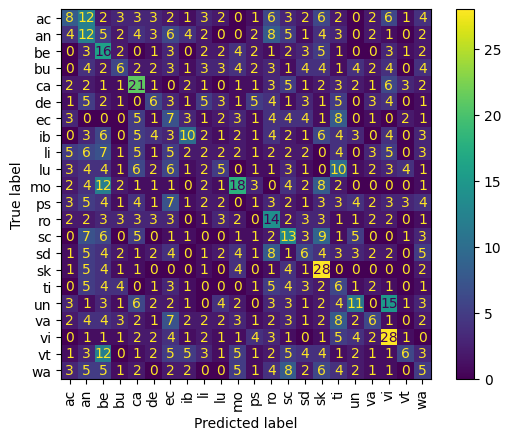

In [17]:
# Confusion matrix for best preforming algorithm Resnet50 with random forest on 300 images per class
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(Ry_test, Ry_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=le.classes_)
disp.plot(xticks_rotation=90)